# Classificação de Plásticos com CNN (TensorFlow/Keras)


# 0 Instalação e Importação

## 0.1 Instalação

In [1]:
#!pip install tensorflow
#!pip install opendatasets

## 0.2 Importação das bibliotecas

In [2]:
import numpy as np
import pandas as pd
import os
import random

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [5]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# 1 CARREGAMENTO DO DATASET

In [6]:
# Caminho do dataset redimensionado (224x224)
base_dir = '../data/Plastic_Classification_224'

In [7]:
#Parâmetros
image_size = (224,224)
batch_size = 32


In [8]:
# Carregamento do dataset
# categorias train
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

Found 1441 files belonging to 7 classes.


In [9]:
# Carregamento do dataset
# categorias validação
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'validation'),
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42
)


Found 416 files belonging to 7 classes.


In [10]:
# Carregamento do dataset
# categorias test
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)

Found 209 files belonging to 7 classes.


In [11]:
# Salvar nomes das classes antes do map
class_names = train_ds.class_names

In [12]:
# Normalização
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# 2 Construção do modelo CNN simples 

### 🧠 Objetivo da Etapa:
Construir um modelo de rede neural convolucional (CNN) capaz de:

- Extrair padrões visuais importantes (textura, forma, bordas),

- Aprender representações discriminantes para cada tipo de plástico,

- Classificar corretamente entre as 7 classes.

| Camada                     | Função                                                                                     |
| -------------------------- | ------------------------------------------------------------------------------------------ |
| `Conv2D(32, (3,3), relu)`  | Extrai **32 mapas de características** com filtros 3x3. Detecta bordas, texturas           |
| `MaxPooling2D(2,2)`        | Reduz o tamanho das imagens, mantendo os padrões mais fortes (reduz ruído)                 |
| `Conv2D(64, (3,3), relu)`  | Agora detecta **padrões mais complexos**, como formas e partes de objetos                  |
| `MaxPooling2D(2,2)`        | Continua reduzindo a dimensionalidade para evitar overfitting e acelerar treino            |
| `Conv2D(128, (3,3), relu)` | Capta ainda **padrões mais abstratos**, como combinação de partes (ex: logotipo + formato) |
| `MaxPooling2D(2,2)`        | Redução final da resolução antes da parte densa                                            |
| `Flatten()`                | Converte as features 3D extraídas em vetor 1D para a rede densa                            |
| `Dense(128, relu)`         | Camada totalmente conectada com 128 neurônios. Aprende combinações complexas dos padrões   |
| `Dense(7, softmax)`        | Saída final com 7 neurônios (1 por classe). Softmax transforma em probabilidades           |


| Decisão                                            | Justificativa                                                    |
| -------------------------------------------------- | ---------------------------------------------------------------- |
| **Filtros pequenos (3x3)**                         | Captam detalhes finos das imagens, muito usados em CNNs modernas |
| **Pooling 2x2**                                    | Evita overfitting, reduz dimensionalidade e melhora performance  |
| **Aumento progressivo de filtros (32 → 64 → 128)** | Aumenta a complexidade do que o modelo pode aprender             |
| **ReLU**                                           | Evita problemas de saturação, acelera o aprendizado              |
| **Softmax + categorical\_crossentropy**            | Ideal para classificação multiclasse com one-hot encoding        |


In [13]:
# CNN simples
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),  
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')
])


In [14]:
# Compilação
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### Entendimento:

🧠 O que são parâmetros?

São os pesos e vieses aprendidos automaticamente pelo modelo durante o treinamento, e definem como ele faz previsões.

| Linha                  | Significado                                                                        |
| ---------------------- | ---------------------------------------------------------------------------------- |
| `Total params`         | Todos os parâmetros (pesos + vieses) da rede                                       |
| `Trainable params`     | Parâmetros que serão atualizados pelo otimizador (ex: Adam)                        |
| `Non-trainable params` | Parâmetros congelados (por exemplo, em transfer learning) — **aqui não há nenhum** |


### 📦 Por que temos 11 milhões de parâmetros?

Mesmo com uma CNN simples, ao chegar na camada Flatten e depois Dense(128) + Dense(7), o número de conexões totalmente conectadas cresce rapidamente.

Por exemplo:

Se a última saída da MaxPooling2D for (26, 26, 128), a Flatten() transforma isso em um vetor de 43264 unidades.

- Flatten → Dense(128) = 43264 × 128 + 128 = 5.537.920

- Dense(128) → Dense(7) = 128 × 7 + 7 = 903

Somando com os parâmetros das camadas convolucionais (que também têm muitos filtros), chega-se facilmente aos 11 milhões.

### ⚠️ Isso é muito?

| Caso                                            | Avaliação                                     |
| ----------------------------------------------- | --------------------------------------------- |
| Para uma CNN simples em imagens pequenas        | **Sim, é relativamente grande**               |
| Para modelos complexos como ResNet/EfficientNet | **É pequeno/modesto**                         |
| Para hardware comum (sem GPU)                   | Pode ser **pesado** e lento                   |
| Para aprendizado                                | **Didaticamente bom**, mas pode ser otimizado |


### ✅ Dicas para reduzir parâmetros se necessário:
Usar menos filtros (ex: 16, 32, 64 em vez de 32, 64, 128)

Adicionar uma camada GlobalAveragePooling2D() em vez de Flatten() para evitar explodir o número de conexões

Reduzir a dimensão da imagem de entrada, se aplicável

# 3 Treinar o modelo

In [15]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 392s 9s/step - accuracy: 0.2029 - loss: 2.2265 - val_accuracy: 0.2476 - val_loss: 1.8168
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 407s 9s/step - accuracy: 0.3151 - loss: 1.7562 - val_accuracy: 0.2716 - val_loss: 1.7673
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 407s 8s/step - accuracy: 0.4054 - loss: 1.5764 - val_accuracy: 0.3582 - val_loss: 1.8657
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 335s 7s/step - accuracy: 0.5463 - loss: 1.3059 - val_accuracy: 0.4014 - val_loss: 1.8928
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 341s 7s/step - accuracy: 0.6066 - loss: 1.1175 - val_accuracy: 0.4014 - val_loss: 1.9927
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 481s 10s/step - accuracy: 0.6923 - loss: 0.8823 - val_accuracy: 0.4014 - val_loss: 2.5116
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 352s 8s/step - accuracy: 0.7655 - loss: 0.6507 - val_accuracy: 0.4135 - val_loss: 2.3574
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 346s 8s/step - accuracy: 0.8251 - loss: 0.5006 - val_accuracy: 0.4351 - 

#### 🧠 Interpretação do treinamento do modelo:

✅ O que está funcionando:
- Acurácia de treino está crescendo bem: de 19% para 93%.

- O modelo conseguiu aprender os padrões do conjunto de treino com eficiência.

- Isso mostra que sua arquitetura tem capacidade de aprendizado suficiente.

#### ⚠️ Problemas claros:

🔴 Overfitting severo

- A validação estagnou entre 32% e 43%, enquanto o treinamento explodiu até 93%.

- A perda de validação está aumentando a cada época (1.8 → 4.1), um sinal clássico de overfitting.

#### 🧪 O que isso significa?

Seu modelo está memorando o treino, mas não generalizando para dados novos.

### 🔧 Causas prováveis

| Causa                              | Indício                                      |
| ---------------------------------- | -------------------------------------------- |
| Modelo com muitos parâmetros (11M) | Overfitting mesmo com pouco treino           |
| Pouca regularização (sem Dropout)  | Nenhuma proteção contra sobreajuste          |
| Dataset pequeno (por classe)       | Algumas classes com <200 imagens             |
| Aumento de dados não utilizado     | Nenhum `ImageDataGenerator` / `augmentation` |
| Arquitetura simples                | Falta de generalização                       |



OBservação:
Aplicar técnicas de regularização (Dropout, BatchNormalization).

Otimizar arquitetura ou testar transfer learning (ResNet, EfficientNet etc.).

# 4 Visualização de desempenho

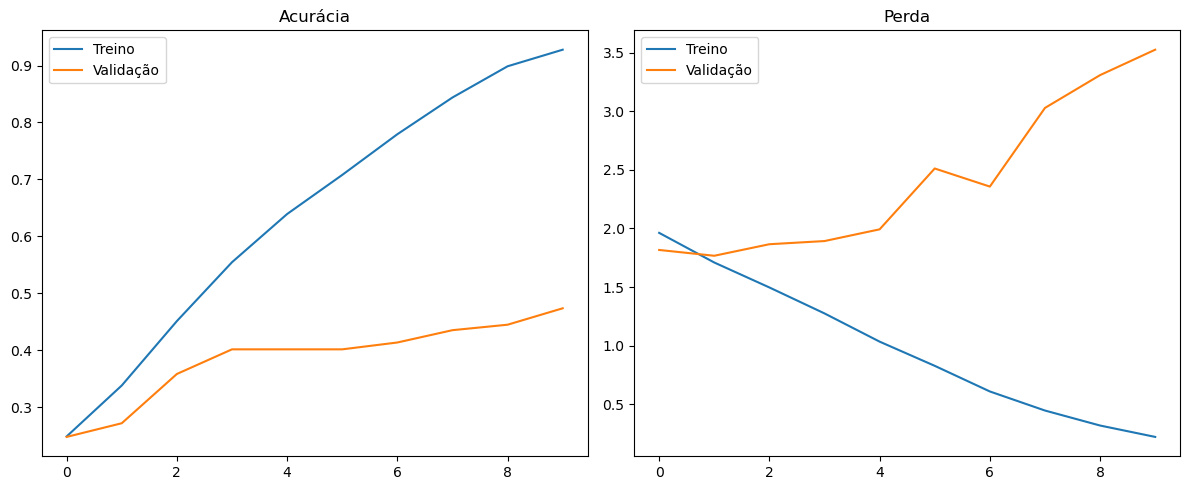

In [16]:
def plot_history(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Treino')
    plt.plot(epochs_range, val_acc, label='Validação')
    plt.title('Acurácia')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Treino')
    plt.plot(epochs_range, val_loss, label='Validação')
    plt.title('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


# 5 Avaliação no conjunto de teste

In [17]:
test_loss, test_acc = model.evaluate(test_ds)
print(f'\n🎯 Acurácia no conjunto de teste: {test_acc:.2%}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3492 - loss: 4.2148

🎯 Acurácia no conjunto de teste: 37.32%


# 6 Conclusão 

Foi verificado que o modelo não performou bem sendo necessario realizar ajustes para corrigir os overfitting e melhorar o desempenho

### Salvar o modelo treinado

In [18]:
# Salvar em formato Keras (.keras)
model.save("./modelos/modelo_cnn_simples_plasticos.keras", include_optimizer=True)


#### Para carregar depois:

'''
    from tensorflow.keras.models import load_model

    modelo_treinado = load_model("modelo_cnn_plasticos.keras")

'''